Lots and lots and lots of thanks to Stack overflow for some of the figures and text-processing.

### Importing all necessary libraries

In [1]:
import numpy as np

import pandas as pd
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.externals import joblib

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier


from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score,confusion_matrix, roc_auc_score,roc_curve,auc

from sklearn.pipeline import Pipeline

/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Data Pre-processing

I first converted the xml file to json using for easier work in Pandas.

In [21]:
df0 = pd.read_json("./data/smokers_surrogate_all.json")
# Joined the training data with ground truth for better data
df = df0.copy()
df = df.T
df = df.reset_index()
df.columns = ['id', 'smoking_status','description']
df.smoking_status.value_counts()

UNKNOWN           315
NON-SMOKER         82
PAST SMOKER        47
CURRENT SMOKER     46
SMOKER             12
Name: smoking_status, dtype: int64

### Merging smoker with current smoker category since smoker category has very few records

In [15]:
df['smoking_status'] = df['smoking_status'].replace({'SMOKER': 'CURRENT SMOKER'})

### Plotting the preliminary data

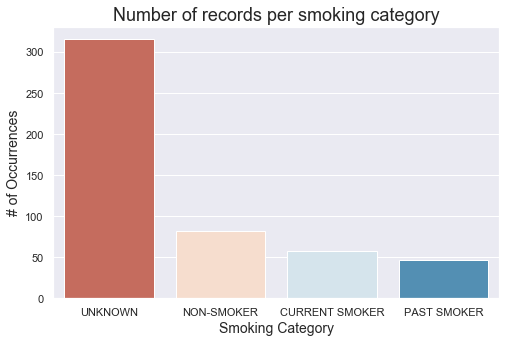

In [16]:
def CategoryCounts(df,column):
    dims = (8, 5)
    fig, ax = plt.subplots(figsize=dims)
    sns.set(style="darkgrid")
    mx = df[column].sort_values()
    sns.countplot(mx, data=df,order = df[column].value_counts().index, palette = sns.color_palette("RdBu", n_colors=4))
    plt.title("Number of records per smoking category", fontsize=18)
    plt.ylabel('# of Occurrences', fontsize=14)
    plt.xlabel('Smoking Category', fontsize=14)
    plt.show()
    
CategoryCounts(df,'smoking_status')

### Adding new custom stop words

In [17]:
stop_words = ['summaryunsigneddisreport','amed','date','patient','mm', 'st','amdischarge','doctor', 'hospital',
    'surgery','pain','problem','discharge','admission','i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves',
    'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 
    'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am','be',
    'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'of', 'at', 'by', 'for', 'about', 'against', 
    'between', 'into', 'through', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over',
    'under', 'further', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'more', 
    'most', 'other', 'some', 'such', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'just', 'don', "don't",
    'should', "should've", 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't",
    'ma', 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'won', "won't", 'wouldn', "wouldn't"
    'aboard','about','above','across','along','an','and','another','any','around','as','at','below','behind','below'
    ,'beneath','beside','beyond','certain','down','during','each','following','for','from','inside','into','its',
    'like','minus','my','near','next','opposite','outside','out','over','plus','round','so','some','than','through',
    'toward','underneath','unlike','yet','under','unsigneded','yregistration']

In [18]:
def process_text(description):
    # Remove punctuation
    no_punc = [char for char in description if char not in string.punctuation]
    no_punc=''.join(no_punc)
    
    # remove numbers from the words
    split_num  = re.split('(\d+)',no_punc)
    split_num=' '.join(split_num)
    
    # remove numbers within the words
    new=re.sub(" \d+", " ", split_num)
    
    # remove the stop words 
    swtext= [word.lower() for word in new.split() if word not in [x.upper() for x in stop_words]]
    text=' '.join(swtext)
    return text

### Process the full dataframe

In [19]:
df['smoking_cat'] = df['smoking_status'].factorize()[0]
category_id_df = df[['smoking_status', 'smoking_cat']].drop_duplicates().sort_values('smoking_cat')
category_to_id = dict(category_id_df.values)

### TF-IDFing

In [20]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 2),
                        preprocessor=process_text,stop_words=stop_words, max_df=0.8)
features = tfidf.fit_transform(df.description).toarray()
labels = df.smoking_cat
features.shape

/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arent', 'couldnt', 'dont', 'neednt', 'shant', 'shes', 'shouldnt', 'shouldve', 'thatll', 'wont', 'wouldntaboard', 'youd', 'youll', 'youre', 'youve'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(502, 26970)

### Getting unigrams and bigrams

In [22]:
N = 3

for smoking_status, smoking_cat in sorted(category_to_id.items()):
    
    features_chi2 = chi2(features, labels == smoking_cat)
    indices = np.argsort(features_chi2[0])
    
    feature_names = np.array(tfidf.get_feature_names())[indices]
    
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    
    print("# '{}':".format(smoking_status))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
    print('---------------------------')

# 'CURRENT SMOKER':
  . Most correlated unigrams:
. smoker
. smokes
. smoking
  . Most correlated bigrams:
. smoking cessation
. pm scheduled
. smoking history
---------------------------
# 'NON-SMOKER':
  . Most correlated unigrams:
. naeelv
. tobacco
. smoke
  . Most correlated bigrams:
. denies tobacco
. history denies
. not smoke
---------------------------
# 'PAST SMOKER':
  . Most correlated unigrams:
. smoked
. painless
. quit
  . Most correlated bigrams:
. per history
. painless jaundice
. history quit
---------------------------
# 'UNKNOWN':
  . Most correlated unigrams:
. preliminary
. information
. smoking
  . Most correlated bigrams:
. please call
. pcp name
. social history
---------------------------


### Separating the knowns and unknowns

In [23]:
def unknown(column):
    if 'UNKNOWN' in column :
        return 1

    else: return 0

df["smoking_unknown"] = df["smoking_status"].apply(unknown)

In [25]:
df.smoking_unknown.value_counts()

1    315
0    187
Name: smoking_unknown, dtype: int64

In [26]:
def train_model(classifier, feature_vector_train, label, feature_vector_test, test_label):
    
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)
    
    # get the predicted probabilty of one class 
    prob = classifier.predict_proba(feature_vector_test)
    pred = prob[:,1]
    
    # output the results
    print ("{} ".format(classifier))
    print ('Accuracy:',accuracy_score(predictions, test_label))
    print ('Recall:',recall_score(predictions, test_label),)
    print ('Precision:',precision_score(predictions, test_label))
    print ('F1:',f1_score(predictions, test_label))
    print ('ROC:',roc_auc_score(test_label,pred))
    print ('CM:',confusion_matrix(predictions, test_label))
    
    return classifier,accuracy_score(predictions, test_label), recall_score(predictions, test_label),precision_score(predictions, test_label), f1_score(predictions, test_label),roc_auc_score(test_label,pred), confusion_matrix(predictions, test_label),pred

In [27]:
def plot_confusion_matrix(cm, xtick, ytick):
    print(cm)

    # Show confusion matrix in a separate window
    fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d',xticklabels=xtick,yticklabels=ytick)
    plt.title('Confusion matrix')
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [28]:
X  = df['description']
y = df['smoking_unknown']

In [29]:
X_train,  X_test,  y_train, y_test  =  train_test_split(X,y,test_size=0.25, random_state=42)

### Layer 1

In [31]:
tfidf_vect = TfidfVectorizer(use_idf= False,norm= 'l2',preprocessor=process_text,ngram_range= (1, 3),
                             min_df= 5,max_features= 2000,max_df=0.9)


tfidf_vect.fit(X_train)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

#### Random Forest

In [33]:
rf,accuracy_rf, recall_rf, precision_rf, f1_rf,roc_rf, cm_rf,pred_rf = train_model(RandomForestClassifier
                                            (n_estimators= 266,min_samples_split=5,min_samples_leaf= 1,
                                             random_state=1,max_features =0.2,max_depth= 50), 
                                                                        xtrain_tfidf, y_train, xtest_tfidf,y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features=0.2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=266,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False) 
Accuracy: 0.9047619047619048
Recall: 0.9375
Precision: 0.9146341463414634
F1: 0.925925925925926
ROC: 0.9739467849223947
CM: [[39  7]
 [ 5 75]]


[[39  7]
 [ 5 75]]


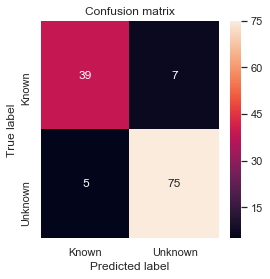

In [34]:
plot_confusion_matrix(cm_rf, ['Known','Unknown'], ['Known','Unknown'])

#### Naive Bayes

In [36]:
tfidf_vect = TfidfVectorizer(use_idf= True,norm= 'l2',preprocessor=process_text,ngram_range= (1, 2),
                             min_df= 2,max_df=0.8)
tfidf_vect.fit(X_train)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

In [37]:
nb,accuracy_nb, recall_nb, precision_nb, f1_nb,roc_nb,cm_nb,pred_nb = train_model(MultinomialNB(alpha=0.1),
                                                                       xtrain_tfidf, y_train, xtest_tfidf,y_test)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True) 
Accuracy: 0.6587301587301587
Recall: 0.8979591836734694
Precision: 0.5365853658536586
F1: 0.6717557251908397
ROC: 0.8151330376940132
CM: [[39 38]
 [ 5 44]]


[[39 38]
 [ 5 44]]


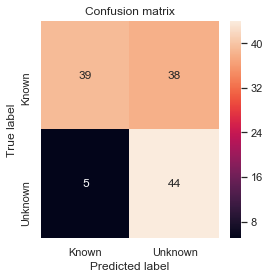

In [38]:
plot_confusion_matrix(cm_nb, ['Known','Unknown'], ['Known','Unknown'])

#### Logistic Regression

In [40]:
tfidf_vect = TfidfVectorizer(use_idf= True,sublinear_tf= True,norm= 'l2',preprocessor=process_text,
                             ngram_range= (1, 3),min_df= 4,max_features=3000,max_df=0.9)
tfidf_vect.fit(X_train)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

In [41]:
lr,accuracy_lr, recall_lr, precision_lr, f1_lr,roc_lr,cm_lr,pred_lr=train_model(LogisticRegression(random_state=15325,penalty='l1',C=1000),xtrain_tfidf, y_train, xtest_tfidf,y_test)



LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=15325, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False) 
Accuracy: 0.9523809523809523
Recall: 0.975
Precision: 0.9512195121951219
F1: 0.9629629629629629
ROC: 0.9830931263858094
CM: [[42  4]
 [ 2 78]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[42  4]
 [ 2 78]]


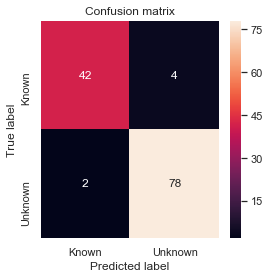

In [42]:
plot_confusion_matrix(cm_lr, ['Known','Unknown'], ['Known','Unknown'])

#### Gradient Boost

In [44]:
tfidf_vect = TfidfVectorizer(use_idf= False,sublinear_tf= True,norm= 'l1',preprocessor=process_text,
                             ngram_range= (1, 2),min_df= 3,max_features=7000,max_df=0.8)
tfidf_vect.fit(X_train)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

In [45]:
gb,accuracy_gb, recall_gb, precision_gb, f1_gb,roc_gb,cm_gb,pred_gb=train_model(GradientBoostingClassifier(min_samples_leaf= 1,
                                 min_samples_split= 20,max_features= 'auto',max_depth=1, learning_rate= 0.05,n_estimators=100,random_state=15325),
            xtrain_tfidf, y_train, xtest_tfidf,y_test)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=1,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=20,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=15325, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False) 
Accuracy: 0.9444444444444444
Recall: 0.9310344827586207
Precision: 0.9878048780487805
F1: 0.9585798816568047
ROC: 0.9836474501108646
CM: [[38  1]
 [ 6 81]]


[[38  1]
 [ 6 81]]


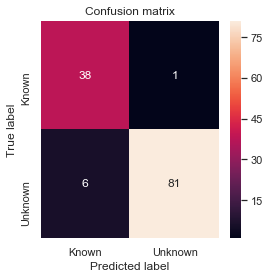

In [47]:
plot_confusion_matrix(cm_gb, ['Known','Unknown'], ['Known','Unknown'])

### Drawing ROC 

<Figure size 432x288 with 0 Axes>

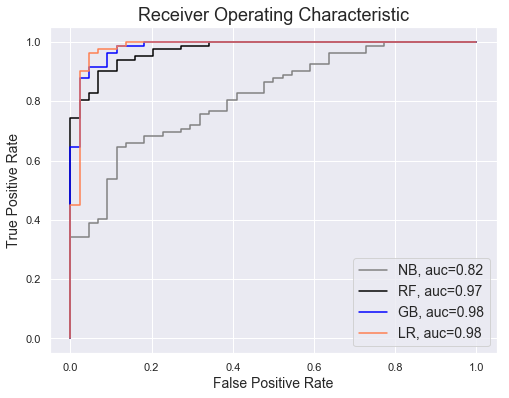

In [49]:
plt.figure(0).clf()
fig, ax = plt.subplots(figsize=(8,6))
plt.title('Receiver Operating Characteristic',fontsize=18)

fpr, tpr, thresh = roc_curve(y_test, pred_nb)
auc = roc_auc_score(y_test, pred_nb)
plt.plot(fpr,tpr,'gray',label="NB, auc="+str(round(auc, 2)))

fpr, tpr, thresh = roc_curve(y_test, pred_rf)
auc = roc_auc_score(y_test, pred_rf)
plt.plot(fpr,tpr,'black',label="RF, auc="+str(round(auc, 2)))

fpr, tpr, thresh = roc_curve(y_test, pred_gb)
auc = roc_auc_score(y_test, pred_gb)
plt.plot(fpr,tpr,'blue',label="GB, auc="+str(round(auc, 2)))

fpr, tpr, thresh = roc_curve(y_test, pred_lr)
auc = roc_auc_score(y_test, pred_lr)
plt.plot(fpr,tpr,'coral',label="LR, auc="+str(round(auc, 2)))

plt.legend(loc = 'lower right',fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)

plt.show()
fig.savefig('layer1roc.jpg')

### Layer 2

In [79]:
df1=df.copy()
secondf=df1[df1.smoking_unknown==0]
secondf.head()

,id,smoking_status,description,smoking_unknown
0,660,PAST SMOKER,156406283HLGMC721364564723/51cy5/28/1993 12:00...,0
1,845,CURRENT SMOKER,487197293PUOMC246626240860219760454/26/2003 12...,0
2,515,CURRENT SMOKER,176318078FIH418969928872/d70h09475611/03/1993 ...,0
3,562,CURRENT SMOKER,245096078FIH917485812/February99735911/3/1992 ...,0
4,633,CURRENT SMOKER,237073320FIH974639079712025160501/26/1998 12:0...,0


In [80]:
def smokerclass(column):
    if 'NON-SMOKER' in column :
        return 1

    else: return 0

secondf["smoking_nonsmoker"] = secondf["smoking_status"].apply(smokerclass)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [81]:
secondf.head()

,id,smoking_status,description,smoking_unknown,smoking_nonsmoker
0,660,PAST SMOKER,156406283HLGMC721364564723/51cy5/28/1993 12:00...,0,0
1,845,CURRENT SMOKER,487197293PUOMC246626240860219760454/26/2003 12...,0,0
2,515,CURRENT SMOKER,176318078FIH418969928872/d70h09475611/03/1993 ...,0,0
3,562,CURRENT SMOKER,245096078FIH917485812/February99735911/3/1992 ...,0,0
4,633,CURRENT SMOKER,237073320FIH974639079712025160501/26/1998 12:0...,0,0


In [82]:
secondf.smoking_nonsmoker.value_counts()

0    105
1     82
Name: smoking_nonsmoker, dtype: int64

In [83]:
X  = secondf['description']
y = secondf['smoking_nonsmoker']

In [84]:
X_train,  X_test,  y_train, y_test  =  train_test_split(X,y,test_size=0.25, random_state=50)

#### Random Forest

In [85]:
tfidf_vect = TfidfVectorizer(use_idf= True,norm= 'l1',preprocessor=process_text,ngram_range= (1, 3),
                             min_df= 2,max_df=0.9)


tfidf_vect.fit(X_train)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

In [86]:
rf, accuracy_rf, recall_rf, precision_rf, f1_rf,roc_rf, cm_rf,pred_rf = train_model(RandomForestClassifier
                                            (n_estimators= 80,min_samples_split=7,min_samples_leaf= 1,
                                             random_state=1,max_features =0.2,max_depth= 30), 
                                                                        xtrain_tfidf, y_train, xtest_tfidf,y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features=0.2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False) 
Accuracy: 0.7021276595744681
Recall: 0.8461538461538461
Precision: 0.4782608695652174
F1: 0.6111111111111112
ROC: 0.8423913043478262
CM: [[22 12]
 [ 2 11]]


[[22 12]
 [ 2 11]]


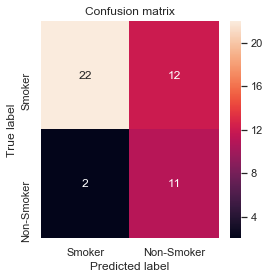

In [87]:
plot_confusion_matrix(cm_rf, ['Smoker', 'Non-Smoker'], ['Smoker', 'Non-Smoker'])

### Logistic Regression

In [88]:
tfidf_vect = TfidfVectorizer(use_idf= True,norm= 'l1',preprocessor=process_text,ngram_range= (1, 3),
                             min_df= 2,max_df=0.9)


tfidf_vect.fit(X_train)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

In [89]:
lr, accuracy_lr, recall_lr, precision_lr, f1_lr,roc_lr,cm_lr,pred_lr=train_model(LogisticRegression(random_state=15325,penalty='l1',C=1000),xtrain_tfidf, y_train, xtest_tfidf,y_test)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=15325, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False) 
Accuracy: 0.5957446808510638
Recall: 0.5769230769230769
Precision: 0.6521739130434783
F1: 0.6122448979591837
ROC: 0.6702898550724637
CM: [[13  8]
 [11 15]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[22 12]
 [ 2 11]]


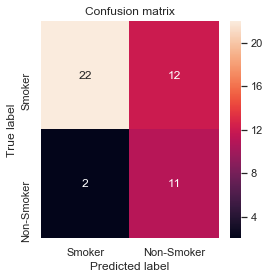

In [90]:
plot_confusion_matrix(cm_rf, ['Smoker', 'Non-Smoker'], ['Smoker', 'Non-Smoker'])

#### Naive Bayes

In [91]:
tfidf_vect = TfidfVectorizer(use_idf= False,sublinear_tf=True,norm= 'l2',preprocessor=process_text,ngram_range= (1,5),
                             min_df= 2,max_df=0.8)
tfidf_vect.fit(X_train)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

In [92]:
nb, accuracy_nb, recall_nb, precision_nb, f1_nb,roc_nb,cm_nb,pred_nb = train_model(MultinomialNB(alpha=0.001),
                                                                       xtrain_tfidf, y_train, xtest_tfidf,y_test)

MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True) 
Accuracy: 0.7872340425531915
Recall: 0.76
Precision: 0.8260869565217391
F1: 0.7916666666666667
ROC: 0.822463768115942
CM: [[18  4]
 [ 6 19]]


[[18  4]
 [ 6 19]]


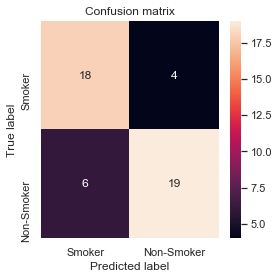

In [93]:
plot_confusion_matrix(cm_nb, ['Smoker', 'Non-Smoker'], ['Smoker', 'Non-Smoker'])

#### Gradient Boost

In [94]:
tfidf_vect = TfidfVectorizer(use_idf= False,sublinear_tf= True,norm= 'l1',preprocessor=process_text,
                             ngram_range= (1, 2),min_df= 4,max_features=7000,max_df=0.8)
tfidf_vect.fit(X_train)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

In [95]:
gb, accuracy_gb, recall_gb, precision_gb, f1_gb,roc_gb,cm_gb,pred_gb=train_model(GradientBoostingClassifier(min_samples_leaf= 1,
                                 min_samples_split= 20,max_features= 'auto',max_depth=1, learning_rate= 0.05,n_estimators=100,random_state=15325),
            xtrain_tfidf, y_train, xtest_tfidf,y_test)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=1,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=20,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=15325, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False) 
Accuracy: 0.8297872340425532
Recall: 0.8947368421052632
Precision: 0.7391304347826086
F1: 0.8095238095238095
ROC: 0.9365942028985507
CM: [[22  6]
 [ 2 17]]


[[22  6]
 [ 2 17]]


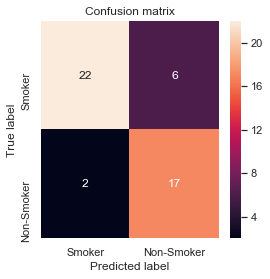

In [96]:
plot_confusion_matrix(cm_gb, ['Smoker', 'Non-Smoker'], ['Smoker', 'Non-Smoker'])

<Figure size 432x288 with 0 Axes>

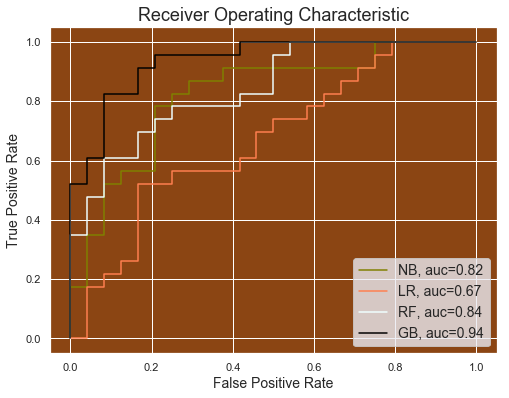

In [97]:
plt.figure(0).clf()
fig, ax = plt.subplots(figsize=(8,6))
plt.title('Receiver Operating Characteristic',fontsize=18)
ax.set_facecolor('saddlebrown')


fpr, tpr, thresh = roc_curve(y_test, pred_nb)
auc = roc_auc_score(y_test, pred_nb)
plt.plot(fpr,tpr,'olive',label="NB, auc="+str(round(auc, 2)))


fpr, tpr, thresh = roc_curve(y_test, pred_lr)
auc = roc_auc_score(y_test, pred_lr)
plt.plot(fpr,tpr,'coral',label="LR, auc="+str(round(auc, 2)))


fpr, tpr, thresh = roc_curve(y_test, pred_rf)
auc = roc_auc_score(y_test, pred_rf)
plt.plot(fpr,tpr,'azure',label="RF, auc="+str(round(auc, 2)))





fpr, tpr, thresh = roc_curve(y_test, pred_gb)
auc = roc_auc_score(y_test, pred_gb)
plt.plot(fpr,tpr,'black',label="GB, auc="+str(round(auc, 2)))



plt.legend(loc = 'lower right',fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)

plt.show()
fig.savefig('layer2roc.jpg')

### Final Layer

In [98]:
thirdf = secondf[secondf.smoking_nonsmoker==0]

In [99]:
def smokerclass3rd(column):
    if 'PAST SMOKER' in column :
        return 1

    else :return 0

thirdf["smoking_past"] = thirdf["smoking_status"].apply(smokerclass3rd)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [101]:
X  = thirdf['description']
y = thirdf['smoking_past']

In [102]:
X_train,  X_test,  y_train, y_test  =  train_test_split(X,y,test_size=0.3, random_state=50)

#### Random Forest

In [103]:
tfidf_vect = TfidfVectorizer(use_idf= True,norm= 'l2',preprocessor=process_text,ngram_range= (2, 5),
                             min_df= 2,max_features= 8000,max_df=0.9)


tfidf_vect.fit(X_train)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

In [104]:
rf, accuracy_rf, recall_rf, precision_rf, f1_rf,roc_rf, cm_rf,pred_rf = train_model(RandomForestClassifier
                                            (n_estimators= 1000,min_samples_split=3,min_samples_leaf= 1,
                                             random_state=1,max_features =0.2,max_depth= 40), 
                                                                        xtrain_tfidf, y_train, xtest_tfidf,y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=40, max_features=0.2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False) 
Accuracy: 0.59375
Recall: 0.5454545454545454
Precision: 0.42857142857142855
F1: 0.4799999999999999
ROC: 0.6130952380952381
CM: [[13  8]
 [ 5  6]]


[[13  8]
 [ 5  6]]


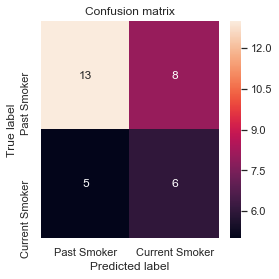

In [106]:
plot_confusion_matrix(cm_rf, ['Past Smoker', 'Current Smoker'], ['Past Smoker', 'Current Smoker'])

#### Gradient Boosting

In [108]:
tfidf_vect = TfidfVectorizer(use_idf= False,sublinear_tf= False,norm= 'l1',preprocessor=process_text,
                             ngram_range= (1, 2),min_df= 4,max_features=4000,max_df=0.8)
tfidf_vect.fit(X_train)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

gb, accuracy_gb, recall_gb, precision_gb, f1_gb,roc_gb,cm_gb,pred_gb=train_model(GradientBoostingClassifier(min_samples_leaf= 1,
                                 min_samples_split= 2,max_features= 'sqrt',max_depth=15, learning_rate= 0.005,n_estimators=200,random_state=15325),
            xtrain_tfidf, y_train, xtest_tfidf,y_test)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.005, loss='deviance', max_depth=15,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=15325, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False) 
Accuracy: 0.65625
Recall: 0.7142857142857143
Precision: 0.35714285714285715
F1: 0.4761904761904762
ROC: 0.5595238095238095
CM: [[16  9]
 [ 2  5]]


[[16  9]
 [ 2  5]]


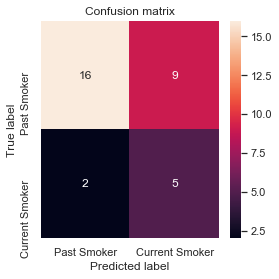

In [109]:
plot_confusion_matrix(cm_gb, ['Past Smoker', 'Current Smoker'], ['Past Smoker', 'Current Smoker'])

### Logistic Regression

In [110]:
tfidf_vect = TfidfVectorizer(use_idf= True,sublinear_tf= False,norm= 'l2',preprocessor=process_text,
                             ngram_range= (2,3),min_df= 1,max_features=5000,max_df=0.9)
tfidf_vect.fit(X_train)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

In [111]:
lr, accuracy_lr, recall_lr, precision_lr, f1_lr,roc_lr,cm_lr,pred_lr=train_model(LogisticRegression(random_state=15325,penalty='l1',C=1000),xtrain_tfidf, y_train, xtest_tfidf,y_test)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=15325, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False) 
Accuracy: 0.5
Recall: 0.4
Precision: 0.2857142857142857
F1: 0.3333333333333333
ROC: 0.49603174603174605
CM: [[12 10]
 [ 6  4]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[12 10]
 [ 6  4]]


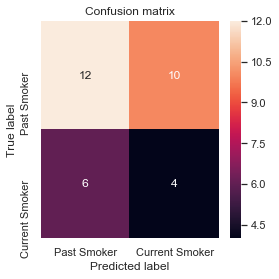

In [112]:
plot_confusion_matrix(cm_lr, ['Past Smoker', 'Current Smoker'], ['Past Smoker', 'Current Smoker'])


### Naive Bayes

In [113]:
tfidf_vect = TfidfVectorizer(use_idf= True,sublinear_tf=False,norm= 'l2',preprocessor=process_text,ngram_range= (1,5),
                             min_df= 1,max_df=0.8)
tfidf_vect.fit(X_train)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

In [114]:
nb, accuracy_nb, recall_nb, precision_nb, f1_nb,roc_nb,cm_nb,pred_nb = train_model(MultinomialNB(alpha=0.0001),
                                                                       xtrain_tfidf, y_train, xtest_tfidf,y_test)

MultinomialNB(alpha=0.0001, class_prior=None, fit_prior=True) 
Accuracy: 0.65625
Recall: 0.6
Precision: 0.6428571428571429
F1: 0.6206896551724138
ROC: 0.6984126984126984
CM: [[12  5]
 [ 6  9]]


[[12  5]
 [ 6  9]]


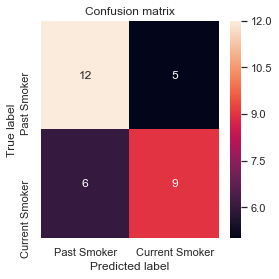

In [115]:
plot_confusion_matrix(cm_nb, ['Past Smoker', 'Current Smoker'], ['Past Smoker', 'Current Smoker'])

<Figure size 432x288 with 0 Axes>

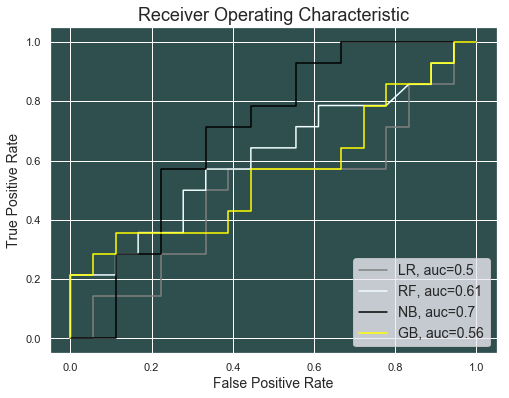

In [116]:
plt.figure(0).clf()
fig, ax = plt.subplots(figsize=(8,6))
plt.title('Receiver Operating Characteristic',fontsize=18)
ax.set_facecolor('darkslategray')





fpr, tpr, thresh = roc_curve(y_test, pred_lr)
auc = roc_auc_score(y_test, pred_lr)
plt.plot(fpr,tpr,'gray',label="LR, auc="+str(round(auc, 2)))


fpr, tpr, thresh = roc_curve(y_test, pred_rf)
auc = roc_auc_score(y_test, pred_rf)
plt.plot(fpr,tpr,'azure',label="RF, auc="+str(round(auc, 2)))



fpr, tpr, thresh = roc_curve(y_test, pred_nb)
auc = roc_auc_score(y_test, pred_nb)
plt.plot(fpr,tpr,'black',label="NB, auc="+str(round(auc, 2)))


fpr, tpr, thresh = roc_curve(y_test, pred_gb)
auc = roc_auc_score(y_test, pred_gb)
plt.plot(fpr,tpr,'yellow',label="GB, auc="+str(round(auc, 2)))



plt.legend(loc = 'lower right',fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)

plt.show()
fig.savefig('layer3roc.jpg')